### Day 11 - conv2d with shared memory

In [ ]:
import pandas as pd
import numpy as np
from math import prod
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm

In [ ]:
from lovely_numpy import Lo
from lovely_tensors import monkey_patch; monkey_patch()
from torch import Tensor
from torch.nn.functional import conv2d

In [ ]:
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
cuda.init()

device = cuda.Device(0)

print(f"Cuda version: {".".join([str(i) for i in cuda.get_version()])}")
print(f"Device:\t{device.name()}")

Cuda version: 12.8.0
Device:	NVIDIA GeForce RTX 3080 Laptop GPU


In [ ]:
cu_file="day_11_conv2d-halo.cu"

In [ ]:
#|output: asis
#|echo: false


c_code = Path(cu_file).read_text()
print(f'''

[{cu_file}](https://github.com/xl0/cuda-100/blob/master/nbs/{cu_file})

::: {{.code-block}}
```
{c_code}
```
:::
''')



[day_11_conv2d-halo.cu](https://github.com/xl0/cuda-100/blob/master/nbs/day_11_conv2d-halo.cu)

::: {.code-block}
```
#include <stdint.h>
#include <stdio.h>

/* This version uses the z grid dimensions for out channels, the inside the the tile is copied into
 * shared memory */
__global__ void conv2d_pad_z_out_shared(float *in,
                                        float *out,
                                        float *filter,
                                        int h,
                                        int w,
                                        int in_channels,
                                        int out_channels,
                                        int filter_size /* Must be an odd number */,
                                        float pad) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    int out_ch = blockIdx.z;

    int filter_r = (filter_size - 1) / 2;

    extern __shared__ float tile[];

  

In [ ]:
## Compiler options for more compile-time warnings.
warn_options=[
    '-Xcompiler', '-Wall',
    '-Xcompiler', '-Wextra',
    '-Xcompiler', '-Wsign-conversion',
    '-Xcompiler', '-Wcast-qual',
    '-Xcompiler', '-Wunused-parameter',
    '-Xcompiler', '-Wdouble-promotion',
    '-Xcompiler', '-Wformat=2',
    '-Xcompiler', '-Wfloat-equal',
    '-Xcompiler', '-Wshadow'
]

In [ ]:
def benchmark_conv2d_pad(ctx, kernel, input, filter, pad, block_size, grid_size, shared=None, repeat=10, warmup=True):
    # input, channel-first
    # - Channel
    # - Height
    # - Width
    assert len(input.shape) == 3

    # Filter shape should be
    # - Out channels
    # - In  channels
    # - Height
    # - Width
    assert len(filter.shape) == 4

    in_ch, h, w = input.shape
    out_ch, in_ch2, fh, fw = filter.shape

    assert fh == fw, f"Only square filters supported, got shape={filter.shape}"

    assert in_ch == in_ch2

    out_shape = (out_ch, h, w)
    # print(f"shared = {shared}")
    # print(f"out_shape={out_shape}")

    gpu_input = cuda.mem_alloc_like(input)
    gpu_filter = cuda.mem_alloc_like(filter)

    out = np.empty(out_shape, dtype=np.float32)

    cuda.memcpy_htod(gpu_input, input)
    cuda.memcpy_htod(gpu_filter, filter)
    ctx.synchronize()

    timing=0
    for _ in range(repeat):
        start = cuda.Event()
        end = cuda.Event()

        gpu_out = cuda.mem_alloc_like(out)

        if warmup:
            kernel(gpu_input, gpu_out, gpu_filter,
                   np.int32(h),
                   np.int32(w),
                   np.int32(in_ch),
                   np.int32(out_ch),
                   np.int32(fh),
                   np.float32(pad),
                   grid=grid_size,
                   block=block_size,
                   shared=shared
                   )
            ctx.synchronize()

        start.record()
        kernel(gpu_input, gpu_out, gpu_filter,
               np.int32(h),
               np.int32(w),
               np.int32(in_ch),
               np.int32(out_ch),
               np.int32(fh),
               np.float32(pad),
               grid=grid_size,
               block=block_size,
               shared=shared)
        end.record()
        end.synchronize()

        timing += end.time_since(start)
    timing /= repeat

    cuda.memcpy_dtoh(out, gpu_out)
    return out, timing;

In [ ]:
in_chan_range = [1, 3, 8, 32, 128, 512]
out_chan_range = [1, 4, 8, 32, 128, 512]

filter_size = [1, 3, 5, 9]

img_size_range = [64, 128, 256, 512, 1024]

# Let's sample from the available options.
n_samples = 50


# Generate all possible combinations
combinations = []
for in_ch in in_chan_range:
    for out_ch in out_chan_range:
        for fs in filter_size:
            for img_size in img_size_range:
                    n = in_ch * out_ch * img_size * img_size

                    # Skip combinatoins that are too large
                    if n < 1024*1024*32*32:
                        combinations.append((in_ch, out_ch, fs, img_size))

n_samples = min(n_samples, len(combinations))
sampled_combinations = np.random.choice(len(combinations), size=n_samples, replace=False)
test_cases = [combinations[i] for i in sampled_combinations]

In [ ]:
tile_width = 32

data = []

# test_cases = [(512, 8, 9, 64)]

ctx = device.make_context()
try:
    mod = SourceModule(Path(cu_file).read_text(), options=warn_options)

    mod_day10 = SourceModule(Path("day_10_conv2d-experiments.cu").read_text(), options=warn_options)

    kernels = {k: mod.get_function(k) for k in ["conv2d_pad_z_out_shared"]} | {k: mod_day10.get_function(k) for k in ["conv2d_pad", "conv2d_pad_z_out"]}

    for tc in tqdm(test_cases):
        ch_in, ch_out, fs, pixels = tc

        array_in = np.random.randn(ch_in, pixels, pixels).astype(np.float32)
        filter = np.random.randn(ch_out, ch_in, fs, fs).astype(np.float32)

        torch_out = conv2d(Tensor(array_in), Tensor(filter), padding="same")

        timings = {}

        for kernel_name, kernel in kernels.items():

            block_size = (tile_width, tile_width, 1)
            grid_size = (((pixels+tile_width-1) // tile_width), ((pixels+tile_width-1) // tile_width), 1 if kernel_name == "conv2d_pad" else ch_out)

            out, timing = benchmark_conv2d_pad(
                ctx=ctx,
                kernel=kernel,
                input=array_in,
                filter=filter,
                pad=0,
                block_size=block_size,
                grid_size=grid_size,
                shared=tile_width * tile_width * 4 if kernel_name == "conv2d_pad_z_out_shared" else 0,
                repeat=3,
                warmup=True
            )

            if np.isclose(out, torch_out).mean() < 0.8:
                print("### Result mismatch ###")
                print(f"Kernel: {kernel_name}")
                print(f"Input shape: {array_in.shape}")
                print(f"Filter shape: {filter.shape}")
                print(f"Result shape: {(filter.shape[0], array_in.shape[1], array_in.shape[2])}")
                print(f"Grid size: {grid_size}")
                print(f"Block size: {block_size}")
                print(f"Total threads: {prod((*grid_size, *block_size))}")

            timings[kernel_name] = timing

        data.append({
            'in_ch': ch_in,
            'out_ch': ch_out,
            'filter_size': fs,
            'img_size': pixels,
            # 'kernel': kernel_name,
        } | timings)

finally:
    ctx.pop()
    ctx.detach()

results = pd.DataFrame(data)

  0%|          | 0/50 [00:00<?, ?it/s]

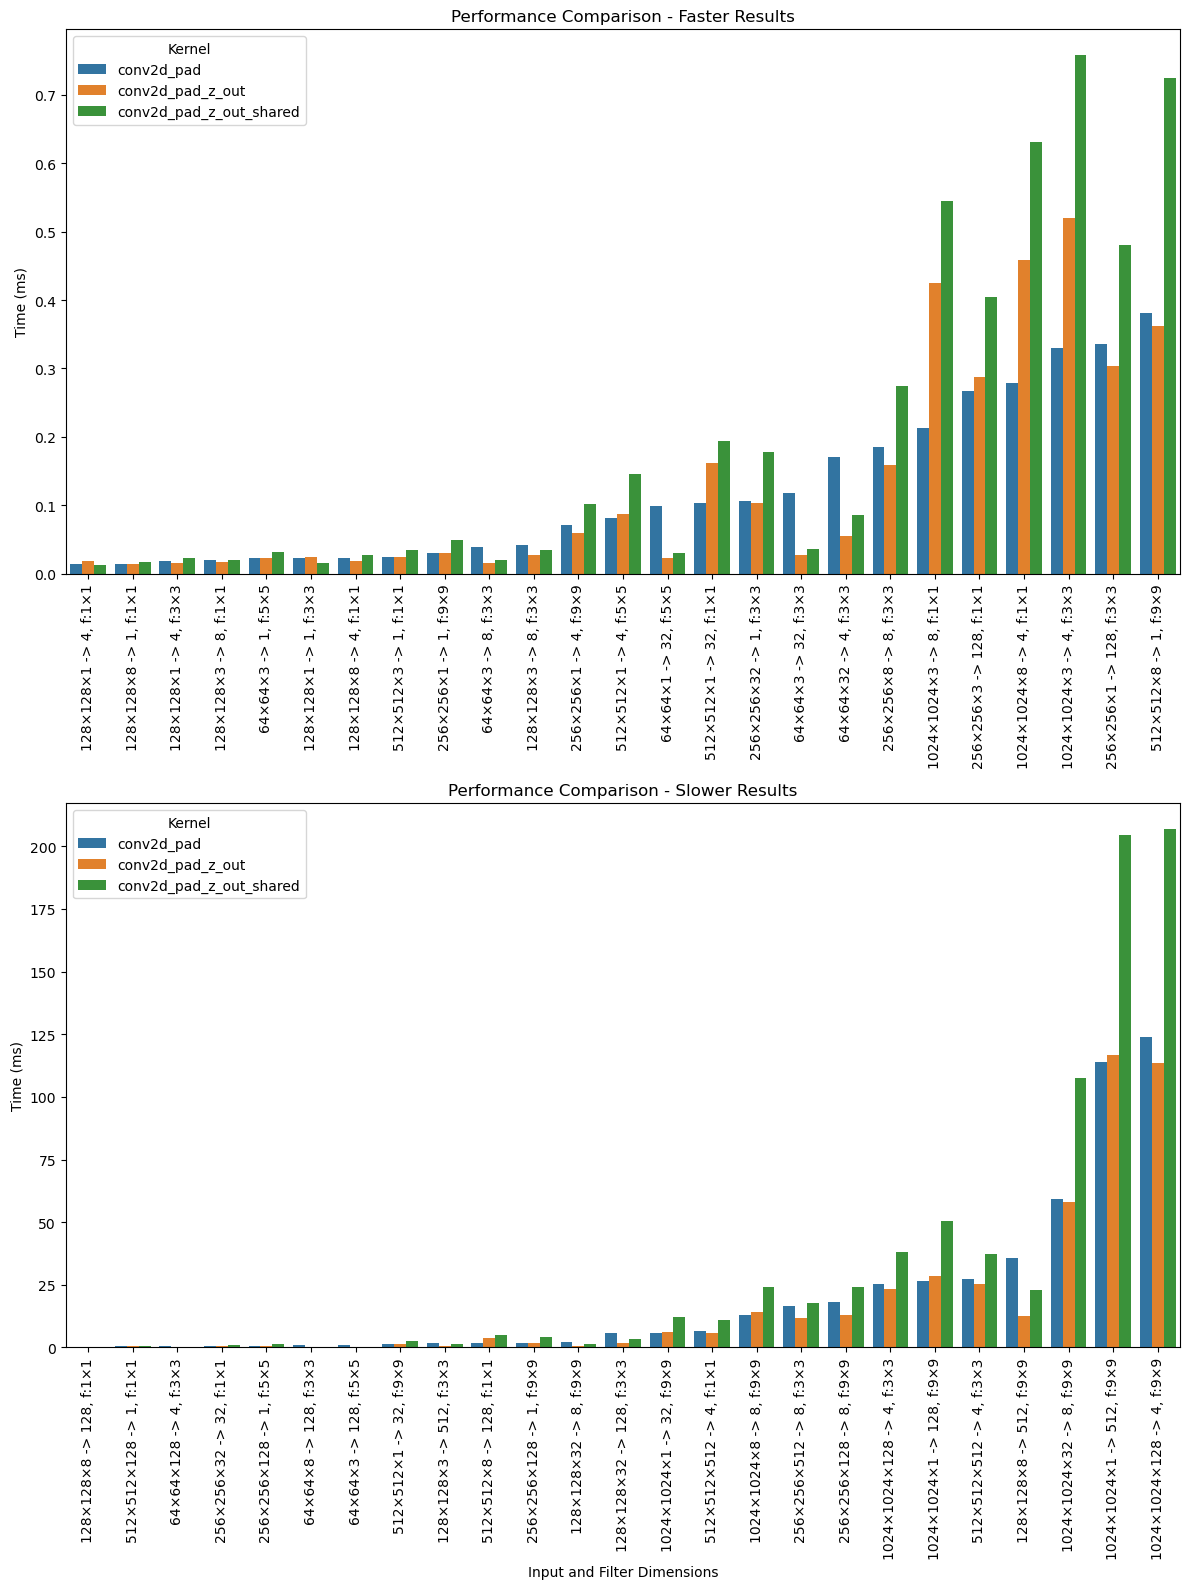

,in_ch,out_ch,filter_size,img_size,conv2d_pad_z_out_shared,conv2d_pad,conv2d_pad_z_out,dimensions
6,1,4,1,128,0.013312,0.014677,0.018432,"128×128×1 -> 4, f:1×1"
37,8,1,1,128,0.017408,0.014677,0.013995,"128×128×8 -> 1, f:1×1"
23,1,4,3,128,0.022560,0.017749,0.015019,"128×128×1 -> 4, f:3×3"
20,3,8,1,128,0.019456,0.019797,0.016384,"128×128×3 -> 8, f:1×1"
35,3,1,5,64,0.032085,0.022187,0.022528,"64×64×3 -> 1, f:5×5"
11,1,1,3,128,0.015701,0.022187,0.024576,"128×128×1 -> 1, f:3×3"
36,8,4,1,128,0.026624,0.023211,0.018432,"128×128×8 -> 4, f:1×1"
16,3,1,1,512,0.034133,0.024917,0.024917,"512×512×3 -> 1, f:1×1"
3,1,1,9,256,0.048811,0.030720,0.030379,"256×256×1 -> 1, f:9×9"
29,3,8,3,64,0.019797,0.038571,0.016043,"64×64×3 -> 8, f:3×3"


In [ ]:
# Sort by conv2d_pad timing
results_sorted = results.sort_values(by='conv2d_pad')

# Create a plot comparing the two kernels
import matplotlib.pyplot as plt
import seaborn as sns

# Create labels for x-axis that include dimensions
results_sorted['dimensions'] = results_sorted.apply(
    lambda row: f"{int(row['img_size'])}×{int(row['img_size'])}×{int(row['in_ch'])} -> {int(row['out_ch'])}, f:{int(row['filter_size'])}×{int(row['filter_size'])}",
    axis=1
)

# Melt the dataframe to get it in the right format for seaborn
melted_results = pd.melt(
    results_sorted,
    id_vars=['in_ch', 'out_ch', 'filter_size', 'img_size', 'dimensions'],
    value_vars=['conv2d_pad', 'conv2d_pad_z_out', 'conv2d_pad_z_out_shared'],
    var_name='kernel',
    value_name='time'
)

# Split the data into two halves based on timing
midpoint = len(results_sorted) // 2
faster_results = melted_results[melted_results['dimensions'].isin(results_sorted['dimensions'][:midpoint])]
slower_results = melted_results[melted_results['dimensions'].isin(results_sorted['dimensions'][midpoint:])]

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))

# Plot faster results in the first subplot
sns.barplot(x='dimensions', y='time', hue='kernel', data=faster_results, ax=ax1)
ax1.set_xlabel('')
ax1.set_ylabel('Time (ms)')
ax1.set_title('Performance Comparison - Faster Results')
ax1.tick_params(axis='x', rotation=90)
ax1.legend(title='Kernel')

# Plot slower results in the second subplot
sns.barplot(x='dimensions', y='time', hue='kernel', data=slower_results, ax=ax2)
ax2.set_xlabel('Input and Filter Dimensions')
ax2.set_ylabel('Time (ms)')
ax2.set_title('Performance Comparison - Slower Results')
ax2.tick_params(axis='x', rotation=90)
ax2.legend(title='Kernel')

# Adjust layout
plt.tight_layout()
plt.show()

# Also display the sorted results table
results_sorted

### For some reason, the version with shared memory is actually slower. Not entirely sure why, because it looks correct